<a href="https://colab.research.google.com/github/imthelizardking/cmp719-project/blob/main/cmp719_project_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Main text

Mount gdrive for saving weights etc.

In [1]:
from google.colab import drive
drive.mount('/content/drive/')
!cd '/content/drive/MyDrive'

Mounted at /content/drive/


Import required packages

In [2]:
!pip install torch torchvision
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
device = torch.device("cuda")

ResNet-56 Model:

In [3]:
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU()
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)  # Skip connection
        out = self.relu(out)
        return out

class ResNet56(nn.Module):
    def __init__(self, num_classes):
        super(ResNet56, self).__init__()
        self.in_planes = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(16, 9, stride=1)
        self.layer2 = self._make_layer(32, 9, stride=2)
        self.layer3 = self._make_layer(64, 9, stride=2)
        self.linear = nn.Linear(64, num_classes)

    def _make_layer(self, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = nn.ReLU()(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = nn.AdaptiveAvgPool2d(1)(out)
        out = torch.flatten(out, 1)
        out = self.linear(out)
        return out

Set configuration for training ResNet-56 w/ cifar-100:

In [4]:
# Set device to GPU if available, otherwise use CPU
device = torch.device("cuda")

custom_transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

custom_transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load CIFAR-100 dataset
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=custom_transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=custom_transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

100%|██████████| 169001437/169001437 [00:11<00:00, 14862102.54it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
# Create ResNet-56 model instance
model_resnet56 = ResNet56(num_classes=100).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
EPOCHS_RESNET56 = 100
LEARNING_RATE_RESNET56 = 0.001
optimizer = optim.AdamW(model_resnet56.parameters(), lr=LEARNING_RATE_RESNET56)

Train ResNet-56 w/ cifar-100

In [ ]:
# Training loop
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
for epoch in range(EPOCHS_RESNET56):  # Number of epochs
    model_resnet56.train()
    train_loss = 0
    train_accuracy = 0
    test_loss = 0
    test_accuracy = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        # Forward pass
        outputs = model_resnet56(inputs)
        loss = criterion(outputs, labels)
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print('#', epoch+1, ' epoch train loss: ', train_loss / len(trainloader))
    train_losses.append(train_loss / len(trainloader))
    # Validation
    model_resnet56.eval()
    correct = 0
    total = 0
    torch._to_functional_tensor = 0
    with torch.no_grad():
        for data in trainloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model_resnet56(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    train_accuracy = 100 * correct / total
    train_accuracies.append(train_accuracy)
    print('Accuracy on training set after epoch %d: %.2f %%' % (epoch + 1, train_accuracy))
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model_resnet56(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_loss = test_loss / len(testloader)
    test_losses.append(test_loss / len(testloader))
    test_accuracy = 100 * correct / total
    test_accuracies.append(test_accuracy)
    print('Accuracy on test set after epoch %d: %.2f %%' % (epoch + 1, test_accuracy))
print('Training finished.')

# 1  epoch train loss:  4.0852354011877114
Accuracy on training set after epoch 1: 10.36 %
Accuracy on test set after epoch 1: 10.53 %
# 2  epoch train loss:  3.530381202697754
Accuracy on training set after epoch 2: 16.37 %
Accuracy on test set after epoch 2: 17.01 %
# 3  epoch train loss:  3.0837778356069188
Accuracy on training set after epoch 3: 22.16 %
Accuracy on test set after epoch 3: 22.76 %
# 4  epoch train loss:  2.7740204767193024
Accuracy on training set after epoch 4: 27.05 %
Accuracy on test set after epoch 4: 26.20 %
# 5  epoch train loss:  2.519889972398958
Accuracy on training set after epoch 5: 34.25 %
Accuracy on test set after epoch 5: 33.95 %
# 6  epoch train loss:  2.3221513328649808
Accuracy on training set after epoch 6: 38.46 %
Accuracy on test set after epoch 6: 38.44 %
# 7  epoch train loss:  2.1522134591246505
Accuracy on training set after epoch 7: 41.64 %
Accuracy on test set after epoch 7: 40.53 %
# 8  epoch train loss:  2.0246778647308155
Accuracy on tr

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff3fc75c670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff3fc75c670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Accuracy on training set after epoch 12: 52.32 %
Accuracy on test set after epoch 12: 49.02 %


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff3fc75c670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
assert self._parent_pid == os.getpid(), 'can only test a child process'    
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff3fc75c670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

# 13  epoch train loss:  1.5782704078937735


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff3fc75c670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff3fc75c670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Accuracy on training set after epoch 13: 57.52 %
Accuracy on test set after epoch 13: 52.68 %


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff3fc75c670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff3fc75c670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

# 14  epoch train loss:  1.5138856230489433


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff3fc75c670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff3fc75c670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Accuracy on training set after epoch 14: 57.77 %
Accuracy on test set after epoch 14: 53.21 %


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff3fc75c670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    
assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child processException ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff3fc75c670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

# 15  epoch train loss:  1.459781635142958


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff3fc75c670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff3fc75c670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Accuracy on training set after epoch 15: 57.22 %
Accuracy on test set after epoch 15: 52.71 %


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff3fc75c670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff3fc75c670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

# 16  epoch train loss:  1.4081135314443838


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff3fc75c670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff3fc75c670>
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    AssertionError: self._shutdown_workers()
can only test a child process  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

    if w.is_alive():
  File "/usr/lib/

Accuracy on training set after epoch 16: 57.71 %
Accuracy on test set after epoch 16: 51.63 %


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff3fc75c670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff3fc75c670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

# 17  epoch train loss:  1.36586770407684


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff3fc75c670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff3fc75c670>if w.is_alive():
Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
      File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
if w.is_alive():    assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/usr/lib/python3.10/multiprocessing/process.py", line 1

Accuracy on training set after epoch 17: 60.77 %
Accuracy on test set after epoch 17: 55.49 %


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff3fc75c670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff3fc75c670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

# 18  epoch train loss:  1.3172995553297155


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff3fc75c670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff3fc75c670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Accuracy on training set after epoch 18: 61.31 %


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff3fc75c670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
Exception ignored in:   File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ff3fc75c670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
        self._shutdown_workers()
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

AssertionError:     can only test a child processif w.is_alive():

  File "/usr/lib/

Accuracy on test set after epoch 18: 54.96 %


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff3fc75c670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child processException ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ff3fc75c670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    
if w.is_alive():
  File "/usr/lib

# 19  epoch train loss:  1.2741037242857696


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff3fc75c670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff3fc75c670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Accuracy on training set after epoch 19: 59.41 %


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff3fc75c670>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ff3fc75c670>Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Traceback (most recent call last):
    self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
        if w.is_alive():if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a

Accuracy on test set after epoch 19: 52.63 %


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff3fc75c670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff3fc75c670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

# 20  epoch train loss:  1.242159666917513
Accuracy on training set after epoch 20: 63.54 %
Accuracy on test set after epoch 20: 56.48 %
# 21  epoch train loss:  1.1997913570355272
Accuracy on training set after epoch 21: 62.26 %
Accuracy on test set after epoch 21: 54.51 %
# 22  epoch train loss:  1.1693617369207885
Accuracy on training set after epoch 22: 64.69 %
Accuracy on test set after epoch 22: 56.53 %
# 23  epoch train loss:  1.1384695654025163
Accuracy on training set after epoch 23: 66.13 %
Accuracy on test set after epoch 23: 57.10 %
# 24  epoch train loss:  1.1020908700230787
Accuracy on training set after epoch 24: 67.93 %
Accuracy on test set after epoch 24: 58.84 %
# 25  epoch train loss:  1.0755139691445528
Accuracy on training set after epoch 25: 67.90 %
Accuracy on test set after epoch 25: 58.16 %
# 26  epoch train loss:  1.0470760571377358
Accuracy on training set after epoch 26: 66.74 %
Accuracy on test set after epoch 26: 57.45 %
# 27  epoch train loss:  1.01467508

Training and Test Losses:

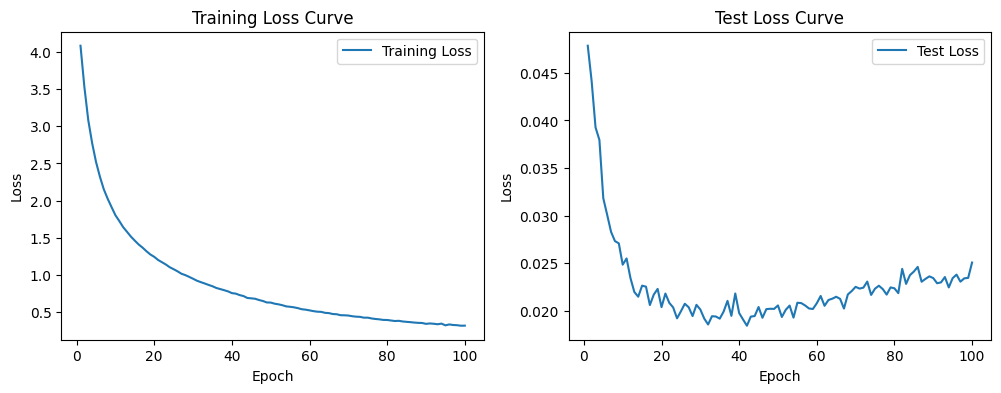

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS_RESNET56+1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS_RESNET56+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss Curve')
plt.legend()
plt.savefig('/content/drive/MyDrive/719_project/results/resnet56_losses.png')

Training and Test Accuracies:

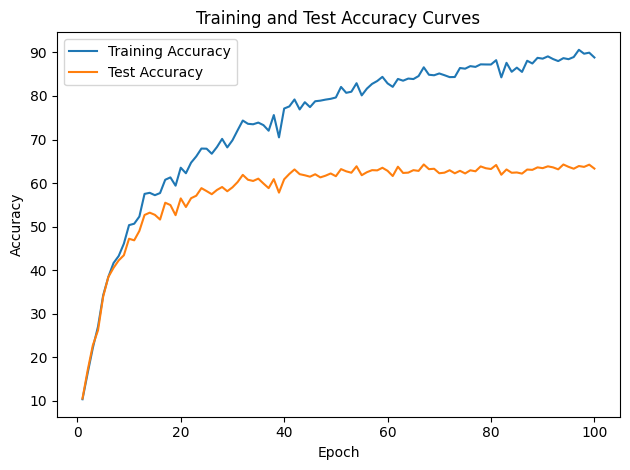

In [ ]:
plt.plot(range(1, EPOCHS_RESNET56+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, EPOCHS_RESNET56+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curves')
plt.legend()

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/719_project/results/resnet56_accuracies.png')
plt.show()

Save trained ResNet-56 weights:

In [ ]:
torch.save(model_resnet56.state_dict(), '/content/drive/MyDrive/719_project/trained_weights/resnet_model_weights.pth')

# **Vision Transformer w/ Feature Guidance:**

Unfortuantely, i couldn't implement vision transformer model on my own and modified the model from link "https://github.com/curt-tigges/vit/blob/main/vit_demo.ipynb".

In [6]:
import os
!pip install torchmetrics
!pip install pytorch_lightning
!pip install lightning-bolts
import pytorch_lightning as pl
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR100
from torch.utils.data import random_split
from torch.utils.data import ConcatDataset, DataLoader
from pl_bolts.transforms.dataset_normalizations import cifar10_normalization


class CIFAR100DataModule(pl.LightningDataModule):
    '''Simple data module that downloads CIFAR-100 and inserts into dataloaders

    This datamodule will download the dataset if it is not present, transform it,
    split it into test, train and validation datasets, and create a dataloader
    for each.

    Args:
        batch_size (int): Desired batch size for dataloaders.
        num_workers (int): Number of CPU threads to use.
        classes (int): Number of classes (100 in CIFAR-100)
        data_dir (str): Directory into which data is located or is to be downloaded
    '''
    def __init__(self, batch_size=128, num_workers=0, classes=100, data_dir=None) -> None:
        super().__init__()
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.classes = classes
        self.data_dir = (os.getcwd() if data_dir is None else data_dir)

    def prepare_data(self) -> None:
        '''Downloads data if it is not located in data_dir.

        Args: None

        Returns: None
        '''
        CIFAR100(root=self.data_dir, train=True, download=True)
        CIFAR100(root=self.data_dir, train=False, download=True)

    def setup(self, stage=None) -> None:
        '''Applies desired transforms and creates datasets

        Args:
            stage (str): Required by Pytorch Lightning. Unused here.

        '''
        train_transforms = transforms.Compose(
            [transforms.RandomHorizontalFlip(),
            transforms.RandomResizedCrop(size=[32,32]),
            transforms.ToTensor(),
            cifar10_normalization()]
        )

        test_transforms = transforms.Compose(
            [transforms.ToTensor(),
            cifar10_normalization()]
        )

        cifar100_train = CIFAR100(
            root=self.data_dir, train=True, download=True,
            transform=train_transforms)
        cifar100_val = CIFAR100(
            root=self.data_dir, train=True, download=True,
            transform=test_transforms)

        # we can use this trick to easily split off the val set from the train set
        pl.seed_everything(42)
        self.train_set, _ = random_split(cifar100_train, [45000, 5000])
        pl.seed_everything(42)
        _, self.val_set = random_split(cifar100_val, [45000, 5000])

        self.test_set = CIFAR100(
            root=self.data_dir, train=False, download=True,
            transform=test_transforms)

    def train_dataloader(self) -> DataLoader:
        '''Returns train dataloader

        Returns:
            Dataloader for training set
        '''
        return DataLoader(self.train_set, batch_size=self.batch_size, num_workers=self.num_workers)

    def val_dataloader(self) -> DataLoader:
        '''Returns validation dataloader

        Returns:
            Dataloader for validation set
        '''
        return DataLoader(self.val_set, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self) -> DataLoader:
        '''Returns test dataloader

        Returns:
            Dataloader for test set
        '''
        return DataLoader(self.test_set, batch_size=self.batch_size, num_workers=self.num_workers)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 728.8/728.8 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.2/721.2 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.8/300.8 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.5/829.5 kB 31.5 MB/s eta 0:00:00
  Attempting uninstall: pytorch-lightning
    Found existing installation: pytorch-lightning 2.0.4
    Uninstalling pytorch-lightning-2.0.4:
      Successfully uninstalled pytorch-lightning-2.0.4


/usr/local/lib/python3.10/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/usr/local/lib/python3.10/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:92: UnderReviewWarning: The feature FeatureMapContrastiveTask is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  contrastive_task: Union[FeatureMapContrastiveTask] = FeatureMapCon

In [7]:

import torch
from torch import nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import OneCycleLR
from torchmetrics.functional import accuracy, precision
import torchmetrics.functional as tf

import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import TQDMProgressBar

In [8]:
# Set this to whatever folder you wish CIFAR-100 to be downloaded into
CIFAR = "/content/drive/MyDrive/719_project/trunk"

In [9]:
def img_to_patch(x, patch_size):
    '''Transforms image into list of patches of the specified dimensions

    Args:
        x (Tensor): Tensor of dimensions B x C x H x W, representing a batch.
        B=Batch size, C=Channel count.
        patch_size (int): Size of one side of (square) patch.

    Returns:
        patch_seq (Tensor): List of patches of dimension B x N x [C * P ** 2],
        where N is the number of patches and P is patch_size.

    Notes:
        May need to add padding
    '''
    B, C, H, W = x.shape

    # reshape to B x C x H_count x H_patch x W_count x W_patch
    x = x.reshape(B, C, H // patch_size, patch_size, W // patch_size, patch_size)
    x = x.permute(0, 2, 4, 1, 3, 5)
    x = x.flatten(1,2)
    x = x.flatten(2, 4)

    return x

In [10]:
class ViTEncoder(nn.Module):
    '''Basic transformer encoder, as specified in the paper

    Args:
        input_dim (int): Dimensions of transformer input (input embed size)
        hidden_dim (int): Size of MLP head
        num_heads (int): Number of self-attention heads
        dropout (float): Probability of dropout
    '''
    def __init__(self, input_dim, hidden_dim, num_heads, dropout=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(input_dim)
        self.attn = nn.MultiheadAttention(input_dim, num_heads)
        self.norm2 = nn.LayerNorm(input_dim)
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_dim, input_dim)
        self.drop1 = nn.Dropout(dropout)
        self.drop2 = nn.Dropout(dropout)

    def forward(self, x):
        out = self.norm1(x)
        out, _ = self.attn(out, out, out)

        # First residual connection
        resid = x + out

        # Pass through MLP layer
        out = self.norm2(resid)
        out = F.gelu(self.fc1(out))
        out = self.drop1(out)
        out = self.fc2(out)
        out = self.drop2(out)

        # Second residual connection
        out = out + resid

        return out

In [11]:
class ViTClassifier(nn.Module):
    '''Encoder-only vision transformer

    Args:
        embed_dim (int): Size of embedding output from linear projection layer
        hidden_dim (int): Size of MLP head
        class_head_dim (int): Size of classification head
        num_encoders (int): Number of encoder layers
        num_heads (int): Number of self-attention heads
        patch_size (int): Size of patches
        num_patches (int): Total count of patches (patch sequence size)
        dropout (float): Probability of dropout
    '''
    def __init__(
        self, embed_size, hidden_size, class_head_dim, num_encoders,
        num_heads, patch_size, num_patches, dropout):
        super().__init__()

        # Key parameters
        self.patch_size = patch_size
        self.num_patches = num_patches

        # Initial projection of flattened patches into an embedding
        self.input = nn.Linear(3*(patch_size**2), embed_size)
        self.drop = nn.Dropout(dropout)

        # Transformer with arbitrary number of encoders, heads, and hidden size
        self.transformer = nn.Sequential(
            *(ViTEncoder(embed_size, hidden_size, num_heads, dropout) for _ in range(num_encoders))
        )

        # Classification head
        self.fc1 = nn.Linear(embed_size, class_head_dim)
        self.fc2 = nn.Linear(class_head_dim, 100)

        # Learnable parameters for class and position embedding
        self.class_embed = nn.Parameter(torch.randn(1, 1, embed_size))
        self.pos_embed = nn.Parameter(torch.randn(1, 1 + num_patches, embed_size))

    def forward(self, x):
        # x will be in the shape B x N x C x P x P
        x = img_to_patch(x, self.patch_size)

        # pass input through projection layer; shape is B x N x (C * P**2)
        x = F.relu(self.input(x))
        B, N, L = x.shape

        # concatenate class embedding and add positional encoding
        class_embed = self.class_embed.repeat(B, 1, 1)
        x = torch.cat([class_embed, x], dim=1)
        x = x + self.pos_embed[:, :N+1]
        x = self.drop(x)

        # apply transformer
        x = x.transpose(0, 1) # result is N x B x (C * P**2)
        x = self.transformer(x)
        x = x[0] # grab the class embedding

        # pass through classification head
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [44]:
class ViTTrainModule(pl.LightningModule):
    '''Encoder-only vision transformer

    Args:
        embed_dim (int): Size of embedding output from linear projection layer
        hidden_dim (int): Size of MLP head
        class_head_dim (int): Size of classification head
        num_encoders (int): Number of encoder layers
        num_heads (int): Number of self-attention heads
        patch_size (int): Size of patches
        num_patches (int): Total count of patches (patch sequence size)
        dropout (float): Probability of dropout
        batch_size (int): Batch size (used for OneCycleLR)
        learning_rate (float): Maximum learning rate
        weight_decay (float): Optimizer weight decay
    '''
    def __init__(
        self,
        embed_dim,
        hidden_dim,
        class_head_dim,
        num_encoders,
        num_heads,
        patch_size,
        num_patches,
        dropout,
        batch_size,
        learning_rate=0.001,
        weight_decay=0.03):
        super().__init__()

        # Key parameters
        self.save_hyperparameters()

        # Transformer with arbitrary number of encoders, heads, and hidden size
        self.model = ViTClassifier(
            embed_dim,
            hidden_dim,
            class_head_dim,
            num_encoders,
            num_heads,
            patch_size,
            num_patches,
            dropout
        )

    def forward(self, x):
        x = self.model(x)
        return x

    def evaluate(self, batch, stage=None):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = tf.accuracy(y_hat, y, task="multiclass", num_classes=100)

        category_prec = precision(y_hat, y.type(torch.int), task="multiclass",average='macro', num_classes=100)
        category_recall = tf.recall(y_hat, y.type(torch.int), task="multiclass", average='macro', num_classes=100)
        category_f1 = tf.f1_score(y_hat, y.type(torch.int), task="multiclass", average='macro', num_classes=100)

        overall_prec = precision(y_hat, y.type(torch.int), task="multiclass", num_classes=100)
        overall_recall = tf.recall(y_hat, y.type(torch.int), task="multiclass", num_classes=100)
        overall_f1 = tf.f1_score(y_hat, y.type(torch.int), task="multiclass", num_classes=100)

        if stage:
            self.log(f"{stage}_loss", loss, prog_bar=True)
            self.log(f"{stage}_acc", acc, prog_bar=True)

            self.log(f"{stage}_cat_prec", category_prec, prog_bar=True)
            self.log(f"{stage}_cat_recall", category_recall, prog_bar=True)
            self.log(f"{stage}_cat_f1", category_f1, prog_bar=True)

            self.log(f"{stage}_ovr_prec", overall_prec, prog_bar=True)
            self.log(f"{stage}_ovr_recall", overall_recall, prog_bar=True)
            self.log(f"{stage}_ovr_f1", overall_f1, prog_bar=True)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        self.evaluate(batch, "val")

    def test_step(self, batch, batch_idx):
        self.evaluate(batch, "test")

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.hparams.learning_rate,
            betas=(0.9,0.999),
            weight_decay=self.hparams.weight_decay)

        steps_per_epoch = 60000 // self.hparams.batch_size

        lr_scheduler_dict = {
            "scheduler":OneCycleLR(
                optimizer,
                self.hparams.learning_rate,
                epochs=self.trainer.max_epochs,
                steps_per_epoch=steps_per_epoch,
                anneal_strategy='cos'
            ),
            "interval":"step",
        }
        return {"optimizer":optimizer, "lr_scheduler":lr_scheduler_dict}

In [45]:
model_kwargs = {
    "embed_dim":256,
    "hidden_dim":512,
    "class_head_dim":512,
    "num_encoders":24,
    "num_heads":8,
    "patch_size":4,
    "num_patches":64,
    "dropout":0.1,
    "batch_size":256,
    "learning_rate":0.001,
    "weight_decay":0.03
}

In [46]:
cifar100 = CIFAR100DataModule(
    batch_size=model_kwargs["batch_size"],
    num_workers=12,
    data_dir=CIFAR)
pl.seed_everything(42)
model_vit = ViTTrainModule(**model_kwargs)

INFO:lightning_fabric.utilities.seed:Global seed set to 42


In [47]:
trainer = pl.Trainer(
    max_epochs=180,
    accelerator='gpu',
    devices=1,
    #logger=wandb_logger, #comment out if not using WandB
    callbacks=[TQDMProgressBar(refresh_rate=10)])

trainer.fit(model_vit, datamodule=cifar100)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:lightning_fabric.utilities.seed:Global seed set to 42


Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type          | Params
----------------------------------------
0 | model | ViTClassifier | 12.9 M
----------------------------------------
12.9 M    Trainable params
0         Non-trainable params
12.9 M    Total params
51.451    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=180` reached.


In [48]:
torch.save(model_vit.state_dict(), '/content/drive/MyDrive/719_project/trained_weights/ViT_model_weights.pth')